In [1]:
import sys
sys.path.append('../lib')

from pathlib import Path
from collections import Counter, defaultdict
import json
from pprint import pprint
from itertools import chain, islice
import math

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as ar
import seaborn as sns

from sklearn import metrics

import pylab as py
from tqdm.notebook import tqdm
# from followthemoney import compare, compare2, model
from followthemoney import compare, model

import compare2_tk as compare2

from profiles import Profile, ProfileCollection, _describe_list, Judgement
import utils

/Users/tuomasketola/Documents/followthemoney-compare/followthemoney_compare/notebooks/../lib/profiles.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
profiles = ProfileCollection.load_dir('../data/profiles/')

In [3]:
profiles.describe()

Number of profiles: 1268
Mean profile size: 1.9014195583596214
STD profile size: 2.380036158831663
Median profile size: 2.0
Unique Entities: 2378
Judgement Counts: [(<Judgement.POSITIVE: 'positive'>, 1823), (<Judgement.NEGATIVE: 'negative'>, 546), (<Judgement.UNSURE: 'unsure'>, 42)]
Mean entity num properties: 5.975114060555786
STD entity num properties: 2.81508843052671
Median entity num properties: 7.0


In [4]:
user_weight = utils.create_user_weights_lookup(profiles)

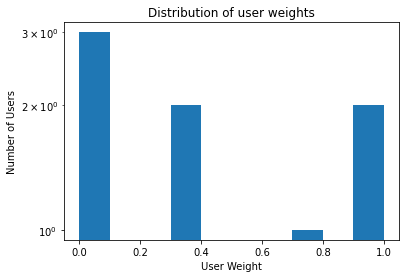

In [5]:
py.hist(user_weight.values())
py.xlabel("User Weight")
py.ylabel("Number of Users")
py.title("Distribution of user weights")
py.gca().set_yscale('log')
py.show()

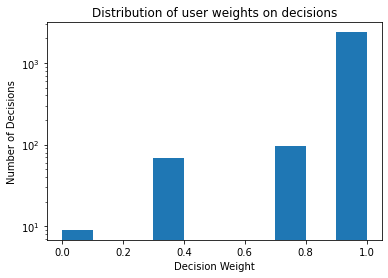

In [6]:
py.hist([user_weight[decision['added_by_id']] for decision in profiles.iter_decisions()])
py.xlabel("Decision Weight")
py.ylabel("Number of Decisions")
py.title("Distribution of user weights on decisions")
py.gca().set_yscale('log')
py.show()

In [7]:
pairs_weighted_sum = Counter()
pairs_count = Counter()
for profile in tqdm(profiles.values()):
    for (e1, e2), judgement in profile.iter_pairs(judgements={Judgement.POSITIVE, Judgement.NEGATIVE}):
        weights = utils.calculate_pair_weights(e1, e2, profile, user_weight)
        pairs_weighted_sum[judgement] += weights.user_weight * weights.pair_weight
        pairs_count[judgement] += 1
pairs_avg = Counter({j: pairs_weighted_sum[j] / pairs_count[j] for j in pairs_count.keys()})

  0%|          | 0/1268 [00:00<?, ?it/s]

/Users/tuomasketola/Documents/followthemoney-compare/lib/python3.9/site-packages/followthemoney-2.5.1-py3.9.egg/followthemoney/compare.py:72: FTMPredictWarning: followthemoney.compare uses a simplified model. Use the package followthemoney-predict for a more accurate entity comparison model
  warnings.warn(FTMPredictWarning())


In [8]:
print("Pairs Weighted Sum:")
print("Total number of pairs:", sum(pairs_weighted_sum.values()))
print("Pair judgements:")
pprint(pairs_weighted_sum.most_common())

print()

print("Pairs Weighted Average:")
print("Total number of pairs:", sum(pairs_avg.values()))
print("Pair judgements:")
pprint(pairs_avg.most_common())

Pairs Weighted Sum:
Total number of pairs: 982.8301088676342
Pair judgements:
[(<Judgement.POSITIVE: 'positive'>, 526.3287460289073),
 (<Judgement.NEGATIVE: 'negative'>, 456.5013628387269)]

Pairs Weighted Average:
Total number of pairs: 1.1805030509083383
Pair judgements:
[(<Judgement.POSITIVE: 'positive'>, 0.6112993565957111),
 (<Judgement.NEGATIVE: 'negative'>, 0.5692036943126271)]


In [9]:
pairs_weights = defaultdict(list)
pairs_compare_score = defaultdict(list)
pairs_compare2_score = defaultdict(list)
for profile in tqdm(profiles.values()):
    pairs = profile.iter_pairs(judgements={Judgement.POSITIVE, Judgement.NEGATIVE})
    for (e1, e2), judgement in pairs:
        pairs_compare_score[judgement].append(compare.compare(model, e1, e2))
        pairs_compare2_score[judgement].append(compare2.compare(model, e1, e2))

  0%|          | 0/1268 [00:00<?, ?it/s]

/Users/tuomasketola/Documents/followthemoney-compare/followthemoney_compare/notebooks/../lib/compare2_tk.py:77: FTMPredictWarning: followthemoney.compare uses a simplified model. Use the package followthemoney-predict for a more accurate entity comparison model
  warnings.warn(FTMPredictWarning())


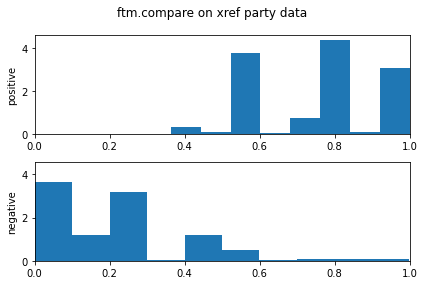

In [10]:
fig, axs = py.subplots(nrows=len(pairs_compare_score), sharey=True)
for ax, (key, values) in zip(axs, pairs_compare_score.items()):
    ax.hist(values, label=key, bins=10, density=True)
    ax.set_ylabel(key.value)
    ax.set_xlim(0, 1)
py.suptitle('ftm.compare on xref party data')
py.tight_layout()
py.show()

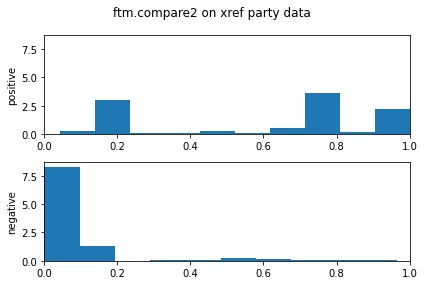

In [11]:
fig, axs = py.subplots(nrows=len(pairs_compare2_score), sharey=True)
for ax, (key, values) in zip(axs, pairs_compare2_score.items()):
    ax.hist(values, label=key, bins=10, density=True)
    ax.set_ylabel(key.value)
    ax.set_xlim(0, 1)
py.suptitle('ftm.compare2 on xref party data')
py.tight_layout()
py.show()

In [ ]:
for judgement, data in pairs_compare_score.items():
    print(judgement.name)
    for threshold in (0.5, 0.7, 0.95):
        N = sum(0.2 < s < threshold for s in data)
        pct = N / len(data) * 100
        print(f'\t{judgement.name} pairs with 0.2 < compare < {threshold}: {N}: {pct:0.2f}%')
    N = sum(s < 0.5 for s in data)
    pct = N / len(data) * 100
    print(f'\t{judgement.name} pairs with 0.0 < compare < 0.5: {N}: {pct:0.2f}%')

In [ ]:
for judgement, data in pairs_compare2_score.items():
    print(judgement.name)
    for threshold in (0.5, 0.7, 0.95):
        N = sum(0.2 < s < threshold for s in data)
        pct = N / len(data) * 100
        print(f'\t{judgement.name} pairs with 0.2 < compare2 < {threshold}: {N}: {pct:0.2f}%')
    N = sum(s < 0.5 for s in data)
    pct = N / len(data) * 100
    print(f'\t{judgement.name} pairs with 0.0 < compare2 < 0.5: {N}: {pct:0.2f}%')

In [ ]:
pairs_compare2_score